# Imports

In [0]:
%matplotlib inline
from __future__ import unicode_literals, print_function, division
from io import open
import unicodedata
import string
import re
import random
from os.path import join

import torch
import torch.nn as nn
import torch.backends.cudnn as cudnn
from torch import optim
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Data processing

In [4]:
from google.colab import drive
path = "/content/gdrive/My Drive/Colab Notebooks/"
drive.mount('/content/gdrive')
!cp /content/gdrive/My\ Drive/Colab\ Notebooks/tsp_20_test.txt .

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/gdrive


In [5]:
# copied from https://github.com/keon/pointer-networks/blob/master/tsp_data.py

import math
import numpy as np
import random
import itertools
from sklearn.model_selection import train_test_split

class Tsp:
    def next_batch(self, batch_size=1):
        X, Y = [], []
        for b in range(batch_size):
#             print("preparing dataset... %s/%s" % (b, batch_size))
            points = self.generate_data()
            solved = self.solve_tsp_dynamic(points)
            X.append(points), Y.append(solved)
        return np.asarray(X), np.asarray(Y)

    def length(self, x, y):
        return (math.sqrt((x[0]-y[0])**2 + (x[1]-y[1])**2))

    def solve_tsp_dynamic(self, points):
        # calc all lengths
        all_distances = [[self.length(x, y) for y in points] for x in points]
        # initial value - just distance from 0 to
        # every other point + keep the track of edges
        A = {(frozenset([0, idx+1]), idx+1): (dist, [0, idx+1])
             for idx, dist in enumerate(all_distances[0][1:])}
        cnt = len(points)
        for m in range(2, cnt):
            B = {}
            for S in [frozenset(C) | {0}
                      for C in itertools.combinations(range(1, cnt), m)]:
                for j in S - {0}:
                    B[(S, j)] = min([(A[(S-{j}, k)][0] + all_distances[k][j],
                                      A[(S-{j}, k)][1] + [j])
                                     for k in S if k != 0 and k != j])
            A = B
        res = min([(A[d][0] + all_distances[0][d[1]], A[d][1])
                   for d in iter(A)])
        return res[1]

    def generate_data(self, N=10):
        radius = 1
        rangeX = (0, 10)
        rangeY = (0, 10)
        qty = N

        deltas = set()
        for x in range(-radius, radius+1):
            for y in range(-radius, radius+1):
                if x*x + y*y <= radius*radius:
                    deltas.add((x, y))

        randPoints = []
        excluded = set()
        i = 0
        while i < qty:
            x = random.randrange(*rangeX)
            y = random.randrange(*rangeY)
            if (x, y) in excluded:
                continue
            randPoints.append((x, y))
            i += 1
            excluded.update((x+dx, y+dy) for (dx, dy) in deltas)
        return randPoints
    
def read_from_file():
    with open("tsp_20_test.txt") as file:
        X = []
        Y = []

        for line in file:
            x, y = line.strip().split(" output ")
            x = x.strip().split()
            x = [float(i) for i in x]
            x = [[x[i], x[i+1]] for i in range(0,len(x)-1,2)]
            y = y.strip().split()
            y = [int(i)-1 for i in y[:-1]]
            X.append(x)
            Y.append(y)
        X = np.array(X)
        Y = np.array(Y)
        return X, Y
    
 
    
p = Tsp()
X, Y = p.next_batch(1000)
# X, Y = read_from_file()
# X, Y = X[:100], Y[:100]
print(X.shape, Y.shape)


(1000, 10, 2) (1000, 10)


In [0]:
class TSPDataset(Dataset):
    def __init__(self, X, Y):
        self.X = X
        self.Y = Y
        self.data_size = X.shape[0]
        self.label_size = Y.shape[1]
        
    def __len__(self):
        return self.data_size
    def __getitem__(self, idx):
        input_tensor = torch.from_numpy(self.X[idx]).float()   
        target_tensor = torch.from_numpy(self.Y[idx]).long()

        return input_tensor, target_tensor

tspdataset = TSPDataset(X, Y)

# Model

In [0]:
class Encoder_GRU(nn.Module):
    def __init__(self, hidden_size, batch_size):
        super(Encoder, self).__init__()
        self.hidden_size = hidden_size
        self.batch_size = batch_size
        self.relu = nn.ReLU()
        
        self.embedding = nn.Linear(2, self.hidden_size)
        self.rnn = nn.GRU(self.hidden_size, self.hidden_size)
        
    def forward(self, input, hidden):
        embedded = self.relu(self.embedding(input)).permute(1, 0, 2)
        output, hidden = self.rnn(embedded, hidden)
        return output.permute(1,0,2) , hidden, embedded.permute(1,0,2)
    
    def init_hidden(self):
        return torch.zeros(1,self.batch_size,self.hidden_size)

class Encoder_LSTM(nn.Module):
    def __init__(self, hidden_size, batch_size):
        super(Encoder_LSTM, self).__init__()
        self.hidden_size = hidden_size
        self.batch_size = batch_size
        self.relu = nn.ReLU()
        self.n_layers = 1
        
        self.embedding = nn.Linear(2, self.hidden_size)
        self.rnn = nn.LSTM(self.hidden_size, self.hidden_size, self.n_layers)
        
        self.c_x = nn.Parameter(torch.zeros(1), requires_grad=False)
        self.h_x = nn.Parameter(torch.zeros(1), requires_grad=False)
        
    def forward(self, input, hidden, context):
        embedded = self.relu(self.embedding(input)).permute(1, 0, 2)
        output, (hidden, context) = self.rnn(embedded, (hidden, context))
        return output.permute(1,0,2) , hidden, embedded.permute(1,0,2), context
    
    def init_hidden(self):
        c_x = self.c_x.unsqueeze(0).unsqueeze(0).repeat(self.n_layers, self.batch_size, self.hidden_size)
        h_x = self.h_x.unsqueeze(0).unsqueeze(0).repeat(self.n_layers, self.batch_size, self.hidden_size)

        return h_x, c_x

class Attention_GRU(nn.Module):
    def __init__(self, hidden_size):
        super(Attention_GRU, self).__init__()
        self.hidden_size = hidden_size
        
        self.W_hidden = nn.Linear(self.hidden_size, self.hidden_size)
        self.W_encoded = nn.Linear(self.hidden_size, self.hidden_size)
        self.V = nn.Parameter(torch.FloatTensor(self.hidden_size), requires_grad=True)
        self.tanh = nn.Tanh()
        self.softmax = nn.Softmax(dim=1)
        
        nn.init.uniform_(self.V, -1, 1)
    
    def forward(self, input, hidden):
        encoder_outputs = self.W_encoded(input).permute(1,0,2)
        hidden = self.W_hidden(hidden)
        summed = self.tanh(encoder_outputs + hidden).permute(0,2,1)
        V = self.V.unsqueeze(0).expand(summed.size(0), -1).unsqueeze(1)
        attn_weights = torch.bmm(V, summed).squeeze().permute(1,0)
        alpha = self.softmax(attn_weights).unsqueeze(1)
        ct = torch.bmm(alpha, input).squeeze()
        return alpha.squeeze(), ct, attn_weights

class Attention_LSTM(nn.Module):
    def __init__(self, hidden_size):
        super(Attention_LSTM, self).__init__()
        self.hidden_size = hidden_size
        self.n_layers = 1
        
        self.W_encoded = nn.Linear(self.hidden_size, self.hidden_size)
        self.W_hidden_context = nn.Linear(self.hidden_size * 1, self.hidden_size)
        self.W_average = nn.Linear(self.n_layers, 1)
        self.V = nn.Parameter(torch.FloatTensor(self.hidden_size), requires_grad=True)
        self._inf = nn.Parameter(torch.FloatTensor([float('-inf')]), requires_grad=False)
        self.tanh = nn.Tanh()
        self.softmax = nn.Softmax(dim=1)
        
        nn.init.uniform_(self.V, -1, 1)
    
    def forward(self, input, hidden, context, mask):
        encoder_outputs = self.W_encoded(input).permute(1,0,2)
#         hidden_context = torch.cat((hidden, context), dim=2)
        hidden_context = hidden
        hidden_context = self.W_hidden_context(hidden_context)
#         hidden_context = torch.mean(hidden_context, dim=0)
        hidden_context = hidden_context.permute(2,1,0)
        hidden_context = self.W_average(hidden_context).permute(2,1,0)
        summed = self.tanh(encoder_outputs + hidden_context).permute(0,2,1)
        V = self.V.unsqueeze(0).expand(summed.size(0), -1).unsqueeze(1)
        attn_weights = torch.bmm(V, summed).squeeze().permute(1,0)
        if (len(attn_weights[mask]) > 0):
            attn_weights[mask] = self.inf[mask]
        alpha = self.softmax(attn_weights).unsqueeze(1)
        ct = torch.bmm(alpha, input).squeeze()
        return alpha.squeeze(), ct, attn_weights
    
    def init_inf(self, size):
        self.inf = self._inf.unsqueeze(1).expand(*size)

class Attention_LSTM_Beam(nn.Module):
    def __init__(self, hidden_size):
        super(Attention_LSTM_Beam, self).__init__()
        self.hidden_size = hidden_size
        self.n_layers = 1
        
        self.W_encoded = nn.Linear(self.hidden_size, self.hidden_size)
        self.W_hidden_context = nn.Linear(self.hidden_size * 1, self.hidden_size)
        self.W_average = nn.Linear(self.n_layers, 1)
        self.V = nn.Parameter(torch.FloatTensor(self.hidden_size), requires_grad=True)
        self._inf = nn.Parameter(torch.FloatTensor([float('-inf')]), requires_grad=False)
        self.tanh = nn.Tanh()
        self.softmax = nn.Softmax(dim=1)
        
        nn.init.uniform_(self.V, -1, 1)
    
    def forward(self, input, hidden, context):
        encoder_outputs = self.W_encoded(input).permute(1,0,2)
#         hidden_context = torch.cat((hidden, context), dim=2)
        hidden_context = hidden
        hidden_context = self.W_hidden_context(hidden_context)
#         hidden_context = torch.mean(hidden_context, dim=0)
        hidden_context = hidden_context.permute(2,1,0)
        hidden_context = self.W_average(hidden_context).permute(2,1,0)
        summed = self.tanh(encoder_outputs + hidden_context).permute(0,2,1)
        V = self.V.unsqueeze(0).expand(summed.size(0), -1).unsqueeze(1)
        attn_weights = torch.bmm(V, summed).squeeze().permute(1,0)
        alpha = self.softmax(attn_weights).unsqueeze(1)
        ct = torch.bmm(alpha, input).squeeze()
        return alpha.squeeze(), ct, attn_weights
        
    
class Decoder_GRU(nn.Module):
    def __init__(self, hidden_size):
        super(Decoder_GRU, self).__init__()
        self.hidden_size = hidden_size
        
        self.rnn = nn.GRU(self.hidden_size*2, self.hidden_size)
        self.attention = Attention_GRU(self.hidden_size)
        
    def forward(self, input, hidden, encoder_outputs, embedded):
        outputs = []
        pointers = []
                
        for _ in range(encoder_outputs.size(1)):
            alpha, ct, attn_weights = self.attention(encoder_outputs, hidden)
            w = torch.cat((input, ct),1).unsqueeze(0)
            _, hidden = self.rnn(w, hidden)
            _, topi = alpha.topk(1)
            topi = topi.squeeze().detach()
            input_ = []
            for j, i in enumerate(topi):
                input_.append(embedded[j,i,:].unsqueeze(0))
            input = torch.cat(input_)
            outputs.append(attn_weights)
            pointers.append(topi)
        
        return torch.stack(outputs,1), torch.stack(pointers,1)
        
class Decoder_LSTM(nn.Module):
    def __init__(self, hidden_size):
        super(Decoder_LSTM, self).__init__()
        self.hidden_size = hidden_size
        self.n_layers = 1
        
        self.rnn = nn.LSTM(self.hidden_size*2, self.hidden_size, self.n_layers)
        self.attention = Attention_LSTM(self.hidden_size)
        
        self.mask = nn.Parameter(torch.ones(1), requires_grad=False)
        
    def forward(self, input, hidden, encoder_outputs, embedded, context):
        outputs = []
        pointers = []
        
        mask = self.mask.repeat(encoder_outputs.size(1)).unsqueeze(0).repeat(encoder_outputs.size(0), 1)
        self.attention.init_inf(mask.size())
                
        for _ in range(encoder_outputs.size(1)):
            alpha, ct, attn_weights = self.attention(encoder_outputs, hidden, context, torch.eq(mask, 0))
            w = torch.cat((input, ct),1).unsqueeze(0)
            _, (hidden, context) = self.rnn(w, (hidden, context))
            
            masked_alpha = alpha * mask
            
            _, topi = masked_alpha.max(1)
            input_ = []
            for j, i in enumerate(topi):
                input_.append(embedded[j,i,:].unsqueeze(0))
                mask[j,i] = 0.
            input = torch.cat(input_)
            outputs.append(alpha)
            pointers.append(topi)
        
        return torch.stack(outputs,1), torch.stack(pointers,1)  

class Decoder_LSTM_Beam(nn.Module):
    def __init__(self, hidden_size):
        super(Decoder_LSTM_Beam, self).__init__()
        self.hidden_size = hidden_size
        self.n_layers = 1
        
        self.rnn = nn.LSTM(self.hidden_size*2, self.hidden_size, self.n_layers)
        self.attention = Attention_LSTM_Beam(self.hidden_size)
        
        self.prev_dist = nn.Parameter(torch.zeros(1), requires_grad=False)
        self.curr_dist = nn.Parameter(torch.zeros(1), requires_grad=False)
                
    def forward(self, input, hidden, encoder_outputs, embedded, context, eval=False):
        
        if eval:
            
            dists = []
            
            batch_size = encoder_outputs.size(0)
            seq_len = encoder_outputs.size(1)
            prev_dist = self.prev_dist.repeat(seq_len).unsqueeze(0).repeat(batch_size, 1)
            
            hiddens = []
            contexts = []
            
            for i in range(seq_len):
                
                if i == 0:
                    alpha, ct, attn_weights = self.attention(encoder_outputs, hidden, context)
                    w = torch.cat((input, ct),1).unsqueeze(0)
                    _, (hidden, context) = self.rnn(w, (hidden, context))
                    
                    hiddens = [hidden] * seq_len
                    contexts = [context] * seq_len
                    
                    prev_dist = alpha
                    dists.append(prev_dist)
                    
                else:
                    curr_dist = self.curr_dist.repeat(seq_len).unsqueeze(0).repeat(batch_size, 1)
#                     curr_dist = torch.zeros(batch_size, seq_len)
                    for j in range(seq_len):
                        a = prev_dist[:,j].unsqueeze(1).unsqueeze(2)
                        
                        alpha, ct, attn_weights = self.attention(encoder_outputs, hiddens[j], contexts[j])
                        w = torch.cat((embedded[:,j,:], ct),1).unsqueeze(0)
                        _, (h, c) = self.rnn(w, (hiddens[j], contexts[j]))
                        hiddens[j] = h
                        contexts[j] = c
                        
                        b = alpha.unsqueeze(1)
                        curr_dist += torch.bmm(a,b).squeeze()
                
                    prev_dist = curr_dist
                    dists.append(prev_dist)
              
#             chosen = set()
            
#             outputs = []
#             pointers = []

#             for d in dists:
#                 for c in chosen:
#                     for k in range(c.size(0)):
#                         d[k,c[k]] = -np.inf
#                 val, i = d.max(1)
#                 chosen.add(i)
#                 outputs.append(d)
#                 pointers.append(i)

            chosen = set()

            dists = torch.stack(dists)

            pointers = []

            for i in range(batch_size):
                dist = dists[:,i,:].squeeze()
                chosen = set()
                seq = [None] * seq_len
                for _ in range(seq_len):
                    j = torch.argmax(dist.flatten())
                    x_ = j % dist.size(0)
                    y_ = (j - x_) / dist.size(0)
                    seq[y_] = x_
                    dist[:,x_] = -np.inf
                    dist[y_,:] = -np.inf

                pointers.append(seq)
            return None, torch.tensor(pointers)

#             return torch.stack(outputs,1), torch.stack(pointers,1)              
            
        else:

            outputs = []
            pointers = []

            for _ in range(encoder_outputs.size(1)):
                alpha, ct, attn_weights = self.attention(encoder_outputs, hidden, context)
                w = torch.cat((input, ct),1).unsqueeze(0)
                _, (hidden, context) = self.rnn(w, (hidden, context))

                _, topi = alpha.max(1)
                input_ = []
                for j, i in enumerate(topi):
                    input_.append(embedded[j,i,:].unsqueeze(0))
                input = torch.cat(input_)
                outputs.append(alpha)
                pointers.append(topi)

            return torch.stack(outputs,1), torch.stack(pointers,1)  
    
class Pointer_LSTM(nn.Module):
    def __init__(self, hidden_size, batch_size):
        super(Pointer_LSTM, self).__init__()
        self.encoder = Encoder_LSTM(hidden_size, batch_size)
        self.decoder = Decoder_LSTM(hidden_size)  
        self.decoder_input0 = nn.Parameter(torch.FloatTensor(batch_size, hidden_size), requires_grad=False)
        
        nn.init.uniform_(self.decoder_input0, -1, 1)
        
    def forward(self, input):
        eh0, ec0 = self.encoder.init_hidden()
        output, hidden, embedded, context = self.encoder(input, eh0, ec0)
        o, p = self.decoder(self.decoder_input0, hidden, output, embedded, context)
        return o, p
  
class Pointer_LSTM_Beam(nn.Module):
    def __init__(self, hidden_size, batch_size):
        super(Pointer_LSTM_Beam, self).__init__()
        self.encoder = Encoder_LSTM(hidden_size, batch_size)
        self.decoder = Decoder_LSTM_Beam(hidden_size)  
        self.decoder_input0 = nn.Parameter(torch.FloatTensor(batch_size, hidden_size), requires_grad=False)
        
        nn.init.uniform_(self.decoder_input0, -1, 1)
        
    def forward(self, input, eval=False):
        eh0, ec0 = self.encoder.init_hidden()
        output, hidden, embedded, context = self.encoder(input, eh0, ec0)
        o, p = self.decoder(self.decoder_input0, hidden, output, embedded, context, eval)
        return o, p
    

# GRU Training


In [0]:
batch_size = 50
dataloader = DataLoader(tspdataset, batch_size=batch_size, shuffle=True, num_workers=4)

hidden_size = 256
encoder = Encoder_GRU(hidden_size, batch_size)
decoder = Decoder_GRU(hidden_size)

decoder_input0 = nn.Parameter(torch.FloatTensor(batch_size, hidden_size), requires_grad=False)
nn.init.uniform_(decoder_input0, -1, 1)

if torch.cuda.is_available():
    USE_CUDA = True
    print('Using GPU, %i devices.' % torch.cuda.device_count())
    encoder.cuda()
    decoder.cuda()
    cudnn.benchmark = True
    decoder_input0 = decoder_input0.cuda()
else:
    print("Not using GPU")
    USE_CUDA = False
    


def train(epochs=10, lr=1e-4, step=1000):
    losses = []
    batch_accs = []
    CCE = torch.nn.CrossEntropyLoss()
    enc_optim = optim.Adam(filter(lambda p: p.requires_grad,
                                encoder.parameters()),
                         lr=lr)

    dec_optim = optim.Adam(filter(lambda p: p.requires_grad,
                                decoder.parameters()),
                         lr=lr)
    
    
    
    steps = 0
    for epoch in range(epochs):
        for input_tensor, target_tensor in dataloader:
            
            eh0 = encoder.init_hidden()      
            
            if USE_CUDA:
                input_tensor = input_tensor.cuda()
                target_tensor = target_tensor.cuda()
                eh0 = eh0.cuda()
            
            output, hidden, embedded = encoder(input_tensor, eh0)

            o, p = decoder(decoder_input0, hidden, output, embedded)    
            loss = CCE(o, target_tensor)
                        
            if steps % step == 0:
            
                acc_sum = (target_tensor == p).sum(dim=1)
                correct = 0.
                for i in range(batch_size):
                    if acc_sum[i].item() == target_tensor.size(1):
                        correct += 1
                acc = correct / batch_size * 100
                batch_accs.append(acc)
                losses.append(loss.item())
                print(steps, acc, loss.item(), p[0], target_tensor[0])
            
            enc_optim.zero_grad()
            dec_optim.zero_grad()
            loss.backward()
#             torch.nn.utils.clip_grad_norm_(encoder.parameters(), 0.5)
#             torch.nn.utils.clip_grad_norm_(decoder_input0, 0.5)
#             torch.nn.utils.clip_grad_norm_(decoder.parameters(), 0.5)
            enc_optim.step()
            dec_optim.step()
            
            steps += batch_size
#     for l, a in zip(losses, batch_accs):
#         print(l,a)

train(800, step=5000)
            

Using GPU, 1 devices.
0 0.0 2.918652057647705 tensor([5, 5, 5, 5, 5, 5, 5, 5, 5, 5], device='cuda:0') tensor([0, 6, 5, 9, 2, 4, 1, 3, 7, 8], device='cuda:0')
5000 0.0 1.9950535297393799 tensor([8, 8, 8, 8, 8, 8, 8, 8, 8, 8], device='cuda:0') tensor([0, 3, 7, 1, 8, 5, 2, 9, 4, 6], device='cuda:0')
10000 0.0 1.9635348320007324 tensor([9, 9, 9, 9, 9, 9, 9, 9, 9, 9], device='cuda:0') tensor([0, 2, 7, 9, 5, 3, 1, 8, 6, 4], device='cuda:0')
15000 0.0 1.9722297191619873 tensor([8, 8, 8, 8, 8, 8, 8, 8, 8, 8], device='cuda:0') tensor([0, 8, 6, 2, 9, 3, 5, 1, 7, 4], device='cuda:0')
20000 0.0 1.9615187644958496 tensor([6, 6, 6, 6, 6, 6, 6, 6, 6, 6], device='cuda:0') tensor([0, 6, 3, 4, 9, 8, 7, 2, 5, 1], device='cuda:0')
25000 0.0 1.9549351930618286 tensor([4, 9, 9, 9, 9, 9, 9, 9, 9, 9], device='cuda:0') tensor([0, 5, 2, 4, 9, 7, 3, 6, 1, 8], device='cuda:0')
30000 0.0 1.968154788017273 tensor([1, 5, 5, 5, 5, 5, 5, 5, 5, 5], device='cuda:0') tensor([0, 1, 7, 4, 6, 9, 3, 2, 8, 5], device='cuda:0'

# LSTM Training

In [22]:
batch_size = 50
dataloader = DataLoader(tspdataset, batch_size=batch_size, shuffle=True, num_workers=4)

hidden_size = 256

pointer_net = Pointer_LSTM_Beam(hidden_size, batch_size)

if torch.cuda.is_available():
    USE_CUDA = True
    print('Using GPU, %i devices.' % torch.cuda.device_count())
    pointer_net.cuda()
    net = torch.nn.DataParallel(pointer_net, device_ids=range(torch.cuda.device_count()))
    cudnn.benchmark = True
else:
    print("Not using GPU")
    USE_CUDA = False
    
lr = 1e-3
    
CCE = torch.nn.CrossEntropyLoss()
pointer_optim = optim.RMSprop(filter(lambda p: p.requires_grad,
                            pointer_net.parameters()),
                     lr=lr)
    
def train(epochs=10, step=1000, name="model"):
    losses = []
    batch_accs = []
    
    for epoch in range(epochs):
        for j, (input_tensor, target_tensor) in enumerate(dataloader):
           
            if USE_CUDA:
                input_tensor = input_tensor.cuda()
                target_tensor = target_tensor.cuda()

            o, p = pointer_net(input_tensor)
            loss = CCE(o, target_tensor)
                        
            if ((len(dataloader))*(epoch) + (j+1)) % step == 0:
                
                _, p = pointer_net(input_tensor, True)
                if USE_CUDA:
                    p = p.cuda()
                
                compare = target_tensor == p
                acc_sum = compare.sum(dim=1)
                correct = 0.
                dist = compare[compare == 0].size()[0]
                for i in range(batch_size):
                    if acc_sum[i].item() == target_tensor.size(1):
                        correct += 1
                acc = correct / batch_size * 100
                batch_accs.append(acc)
                losses.append(loss.item())
                print("epoch {}: batch: {}/{} dist: {} loss: {}".format(epoch+1,j+1,len(dataloader),dist,loss.item()), p[0], target_tensor[0])
                to_save = {"pointer_net_state_dict" : pointer_net.state_dict(), "pointer_optim_state_dict" : pointer_optim.state_dict(), "epoch" : epoch, "j" : j}
                torch.save(to_save, join(path, "pointer_net_"+name+"_"+str(epoch)+".pt"))
            
            pointer_optim.zero_grad()
            loss.backward()
#             torch.nn.utils.clip_grad_norm_(pointer_net.parameters(), 0.5)
            pointer_optim.step()
            
#     for l, a in zip(losses, batch_accs):
#         print(l,a)

train(1000, step=20*40, name="masked_beam")
            

Using GPU, 1 devices.
epoch 40: batch: 20/20 dist: 394 loss: 2.178508996963501 tensor([0, 3, 4, 1, 5, 2, 6, 8, 7, 9], device='cuda:0') tensor([0, 4, 8, 5, 7, 2, 3, 1, 6, 9], device='cuda:0')
epoch 80: batch: 20/20 dist: 370 loss: 2.1122777462005615 tensor([0, 1, 6, 3, 4, 8, 2, 9, 5, 7], device='cuda:0') tensor([0, 5, 1, 7, 8, 9, 2, 3, 4, 6], device='cuda:0')
epoch 120: batch: 20/20 dist: 379 loss: 2.0374844074249268 tensor([0, 2, 1, 5, 3, 4, 6, 8, 7, 9], device='cuda:0') tensor([0, 2, 1, 5, 8, 4, 9, 3, 6, 7], device='cuda:0')
epoch 160: batch: 20/20 dist: 377 loss: 2.0150139331817627 tensor([0, 7, 1, 5, 4, 9, 8, 2, 3, 6], device='cuda:0') tensor([0, 2, 7, 8, 9, 4, 3, 1, 6, 5], device='cuda:0')
epoch 200: batch: 20/20 dist: 367 loss: 1.963767170906067 tensor([0, 4, 1, 7, 9, 8, 2, 6, 3, 5], device='cuda:0') tensor([0, 2, 8, 5, 1, 9, 7, 3, 6, 4], device='cuda:0')
epoch 240: batch: 20/20 dist: 368 loss: 1.942868709564209 tensor([0, 1, 6, 4, 7, 3, 2, 9, 8, 5], device='cuda:0') tensor([0, 1,

In [0]:
torch.save(pointer_net.state_dict(), join(path,"masked_pointernet_final.pt"))


In [25]:
total_missed = 0.
total_dist = 0.

opt_total = 0.

dataloader = DataLoader(tspdataset, batch_size=batch_size, shuffle=True, num_workers=4)

for j, (input_tensor, target_tensor) in enumerate(dataloader):
           
    if USE_CUDA:
        input_tensor = input_tensor.cuda()
        target_tensor = target_tensor.cuda()

    _, p = pointer_net(input_tensor, True)
    if USE_CUDA:
        p = p.cuda()
    
#     print(input_tensor.size(), target_tensor.size())

    compare = target_tensor == p
    acc_sum = compare.sum(dim=1)
    dist = compare[compare == 0].size()[0]
    total_missed += dist
    
    tour_dist = 0.
    opt_dist = 0.
    
    for k in range(50):
#         print(input_tensor[k,])
        for i in range(9):

#             print(input_tensor[k,p[k,i],:], input_tensor[k,p[k,i+1],:])
#             print(p[k,i])
            x = torch.pow(input_tensor[k,p[k,i],0] - input_tensor[k,p[k,i+1],0],2)
            y = torch.pow(input_tensor[k,p[k,i],1] - input_tensor[k,p[k,i+1],1],2)
            td = torch.sqrt(x + y)
            
            x_opt = torch.pow(input_tensor[k,target_tensor[k,i],0] - input_tensor[k,target_tensor[k,i+1],0],2)
            y_opt = torch.pow(input_tensor[k,target_tensor[k,i],1] - input_tensor[k,target_tensor[k,i+1],1],2)
            td_opt = torch.sqrt(x_opt + y_opt)
#             print(td)

            tour_dist += td
            opt_dist += td_opt
        
    total_dist += tour_dist
    opt_total += opt_dist
    
print(total_dist / (50. * len(dataloader)))
print(opt_total / (50. * len(dataloader)))

torch.Size([50, 10, 2]) torch.Size([50, 10])
torch.Size([50, 10, 2]) torch.Size([50, 10])
torch.Size([50, 10, 2]) torch.Size([50, 10])
torch.Size([50, 10, 2]) torch.Size([50, 10])
torch.Size([50, 10, 2]) torch.Size([50, 10])
torch.Size([50, 10, 2]) torch.Size([50, 10])
torch.Size([50, 10, 2]) torch.Size([50, 10])
torch.Size([50, 10, 2]) torch.Size([50, 10])
torch.Size([50, 10, 2]) torch.Size([50, 10])
torch.Size([50, 10, 2]) torch.Size([50, 10])
torch.Size([50, 10, 2]) torch.Size([50, 10])
torch.Size([50, 10, 2]) torch.Size([50, 10])
torch.Size([50, 10, 2]) torch.Size([50, 10])
torch.Size([50, 10, 2]) torch.Size([50, 10])
torch.Size([50, 10, 2]) torch.Size([50, 10])
torch.Size([50, 10, 2]) torch.Size([50, 10])
torch.Size([50, 10, 2]) torch.Size([50, 10])
torch.Size([50, 10, 2]) torch.Size([50, 10])
torch.Size([50, 10, 2]) torch.Size([50, 10])
torch.Size([50, 10, 2]) torch.Size([50, 10])
tensor(47.8736, device='cuda:0')
tensor(27.3511, device='cuda:0')


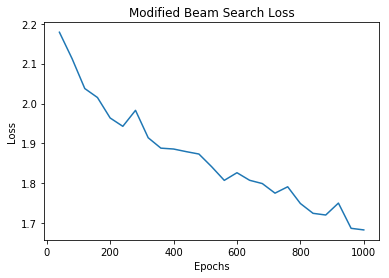

In [1]:
X = [40, 80, 120, 160, 200, 240, 280, 320, 360, 400, 440, 480, 520, 560, 600, 640, 680, 720, 760, 800, 840, 880, 920, 960, 1000]
Y = [2.178508996963501, 2.1122777462005615, 2.0374844074249268, 2.0150139331817627, 1.963767170906067, 1.942868709564209, 1.9829071760177612, 1.9142353534698486, 1.8882086277008057, 1.8860129117965698, 1.8794472217559814, 1.8734612464904785, 1.8418394327163696, 1.8075056076049805, 1.8266631364822388, 1.8076831102371216, 1.7994813919067383, 1.7754749059677124, 1.7914435863494873, 1.7495747804641724, 1.7249466180801392, 1.7207109928131104, 1.7505592107772827, 1.6873786449432373, 1.6833927631378174]

import matplotlib.pyplot as plt

plt.title("Modified Beam Search Loss")
plt.ylabel('Loss')
plt.xlabel('Epochs')
plt.plot(X,Y)
